# Compare group knockoffs

This repeats the **AR1 and AR1(corr)** simulation in Fig 9 of [Spector and Janson](https://projecteuclid.org/journals/annals-of-statistics/volume-50/issue-1/Powerful-knockoffs-via-minimizing-reconstructability/10.1214/21-AOS2104.short).  

+ target FDR = 10%
+ We generate equi, SDP, MVR, and ME group knockoffs using the true covariance matrix
+ Groups are defined via average linkake hierarchical clustering with cutoff varied as a parameter between 0.1-0.9 (larger value means smaller group sizes)

Simulation scripts



In [1]:
using Knockoffs
using LinearAlgebra
using Random
using StatsBase
using Statistics
using ToeplitzMatrices
using Distributions
using ProgressMeter
using DataFrames, CSV
using DelimitedFiles

function run_group_knockoff_comparison(seed, ns, ar1_corr::Bool)
    target_fdr = 0.1
    m = 5
    p = 1000 # 500
    k = 50
    true_mu = zeros(p)

    # storage for results
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    sdp_subopt_powers, sdp_subopt_fdrs, sdp_subopt_times, sdp_subopt_ssums, sdp_subopt_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    me_powers, me_fdrs, me_times, me_ssums, me_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_mineigval = zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns)), zeros(length(ns))
    num_groups = zeros(length(ns))

    # simulate Σ
    Random.seed!(seed)
    Σ = simulate_AR1(p, a=3, b=1)
    L = cholesky(Σ).L

    # simulate beta
    βtrue = zeros(p)
    if ar1_corr
        beta_start = rand(k:p-k)
        βtrue[beta_start:beta_start+k-1] .= randn(k)
    else
        βtrue[1:k] .= randn(k)
        shuffle!(βtrue)
    end

    for (idx, n) in enumerate(ns)
        try
            Random.seed!(seed)

            # simulate X
            X = randn(n, p) * L
            zscore!(X, mean(X, dims=1), std(X, dims=1))

            # simulate y
            ϵ = randn(n)
            y = X * βtrue + ϵ
            
            # define group
            groups = hc_partition_groups(X)
            num_groups[idx] += length(unique(groups))
            @show length(unique(groups))

            # find truly causal groups
            correct_groups = groups[findall(!iszero, βtrue)] |> unique

            # equi
            Random.seed!(seed)
            equi_t = @elapsed equi = modelX_gaussian_group_knockoffs(
                X, :equi, groups, true_mu, Σ, 
                m = m,
            )
            equi_ko_filter = fit_lasso(y, equi)
            fdr_idx = findfirst(x -> x == target_fdr, equi_ko_filter.fdr_target)
            selected = equi_ko_filter.selected[fdr_idx]
            equi_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            equi_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            equi_ssum = sum(abs.(equi_ko_filter.ko.S))

            # sdp
            Random.seed!(seed)
            sdp_t = @elapsed sdp = modelX_gaussian_group_knockoffs(
                X, :sdp, groups, true_mu, Σ, 
                m = m, tol=0.0001,
            )
            sdp_ko_filter = fit_lasso(y, sdp)
            selected = sdp_ko_filter.selected[fdr_idx]
            sdp_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            sdp_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            sdp_ssum = sum(abs.(sdp_ko_filter.ko.S))

            # subopt-sdp
#             subopt_sdp_t = @elapsed sdp_subopt = modelX_gaussian_group_knockoffs(
#                 X, :sdp_subopt, groups, #true_mu, Σ, 
#                 m = m,
#             )
#             sdpopt_ko_filter = fit_lasso(y, sdp_subopt)
#             selected = sdpopt_ko_filter.selected[fdr_idx]
#             subopt_sdp_power = length(intersect(correct_groups, selected)) / length(correct_groups)
#             subopt_sdp_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
#             subopt_sdp_ssum = sum(abs.(sdpopt_ko_filter.ko.S))

            # ME
            Random.seed!(seed)
            me_t = @elapsed me = modelX_gaussian_group_knockoffs(
                X, :maxent, groups, true_mu, Σ, 
                m = m, 
            )
            me_ko_filter = fit_lasso(y, me)
            selected = me_ko_filter.selected[fdr_idx]
            me_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            me_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            me_ssum = sum(abs.(me_ko_filter.ko.S))

            # MVR
            Random.seed!(seed)
            mvr_t = @elapsed mvr = modelX_gaussian_group_knockoffs(
                X, :mvr, groups, true_mu, Σ, 
                m = m, 
            )
            mvr_ko_filter = fit_lasso(y, mvr)
            selected = mvr_ko_filter.selected[fdr_idx]
            mvr_power = length(intersect(correct_groups, selected)) / length(correct_groups)
            mvr_fdr = length(setdiff(selected, correct_groups)) / max(1, length(selected))
            mvr_ssum = sum(abs.(mvr_ko_filter.ko.S))

            # update counters if all methods succeeded
            equi_powers[idx] += equi_power
            equi_fdrs[idx] += equi_fdr
            equi_times[idx] += equi_t
            equi_ssums[idx] += equi_ssum
            sdp_powers[idx] += sdp_power
            sdp_fdrs[idx] += sdp_fdr
            sdp_times[idx] += sdp_t
            sdp_ssums[idx] += sdp_ssum
#             sdp_subopt_powers[idx] += subopt_sdp_power
#             sdp_subopt_fdrs[idx] += subopt_sdp_fdr
#             sdp_subopt_times[idx] += subopt_sdp_t
#             sdp_subopt_ssums[idx] += subopt_sdp_ssum
            me_powers[idx] += me_power
            me_fdrs[idx] += me_fdr
            me_times[idx] += me_t
            me_ssums[idx] += me_ssum
            mvr_powers[idx] += mvr_power
            mvr_fdrs[idx] += mvr_fdr
            mvr_times[idx] += mvr_t
            mvr_ssums[idx] += mvr_ssum

            println("equi (n $n): power = $(equi_power), fdr = $(equi_fdr), t=$(equi_t), sum(s) = $(equi_ssum)")
#             println("subopt-SDP (c_corr $c_corr): power = $(subopt_sdp_power), fdr = $(subopt_sdp_fdr), t=$(subopt_sdp_t), sum(s) = $(subopt_sdp_ssum)")
            println("SDP (n $n): power = $(sdp_power), fdr = $(sdp_fdr), t=$(sdp_t), sum(s) = $(sdp_ssum)")
            println("ME (n $n): power = $(me_power), fdr = $(me_fdr), t=$(me_t), sum(s) = $(me_ssum)")
            println("mvr (n $n): power = $(mvr_power), fdr = $(mvr_fdr), t=$(mvr_t), sum(s) = $(mvr_ssum)\n")
        catch
            continue
        end
    end
    
    return equi_powers, equi_fdrs, equi_times, equi_ssums, 
        sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, 
#         sdp_subopt_powers, sdp_subopt_fdrs, sdp_subopt_times, sdp_subopt_ssums, 
        me_powers, me_fdrs, me_times, me_ssums, 
        mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, 
        num_groups
end

function run_one_simulation(seed, ar1_corr::Bool)
    outdir = ar1_corr ? "/home/groups/sabatti/group_knockoff_simulations/AR1_corr/sim$seed" : 
        "/home/groups/sabatti/group_knockoff_simulations/AR1/sim$seed"
    isdir(outdir) || mkpath(outdir)

    # run simulation
#     c_corrs = 0.1:0.2:0.9 # 1 = ungrouped, lower = larger groups
    ns = 250:250:1000
    equi_powers, equi_fdrs, equi_times, equi_ssums, 
        sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, 
        me_powers, me_fdrs, me_times, me_ssums, 
        mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, 
        num_groups = run_group_knockoff_comparison(seed, ns, ar1_corr)

    # save results
    for (i, n) in enumerate(ns)
        df = DataFrame(method = String[], power=Float64[], fdr=Float64[], time=Float64[], ssum=Float64[])
        push!(df, ["equi", equi_powers[i], equi_fdrs[i], equi_times[i], equi_ssums[i]])
        push!(df, ["sdp", sdp_powers[i], sdp_fdrs[i], sdp_times[i], sdp_ssums[i]])
        push!(df, ["me", me_powers[i], me_fdrs[i], me_times[i], me_ssums[i]])
        push!(df, ["mvr", mvr_powers[i], mvr_fdrs[i], mvr_times[i], mvr_ssums[i]])
        CSV.write(joinpath(outdir, "n$n.csv"), df)
    end
    writedlm(joinpath(outdir, "num_groups.txt"), num_groups)
end

seed = 1111
corr = true
# seed = parse(Int, ARGS[1])
# corr = parse(Bool, ARGS[2])
run_one_simulation(seed, corr)
println("finished.")


length(unique(groups)) = 618
equi (n 250): power = 0.1935483870967742, fdr = 0.0, t=3.719017597, sum(s) = 10.643158784664159
SDP (n 250): power = 0.06451612903225806, fdr = 0.0, t=496.459637629, sum(s) = 267.04190087323116
ME (n 250): power = 0.16129032258064516, fdr = 0.0, t=45.954347687, sum(s) = 343.92938457613286
mvr (n 250): power = 0.22580645161290322, fdr = 0.0, t=102.505813968, sum(s) = 299.8928315723887

length(unique(groups)) = 617
equi (n 500): power = 0.09375, fdr = 0.0, t=3.746165184, sum(s) = 5.130052391250649
SDP (n 500): power = 0.53125, fdr = 0.10526315789473684, t=479.309693498, sum(s) = 261.85097539681846
ME (n 500): power = 0.8125, fdr = 0.10344827586206896, t=49.204323811, sum(s) = 346.9714462739275
mvr (n 500): power = 0.6875, fdr = 0.18518518518518517, t=95.399803421, sum(s) = 303.1290470641343

length(unique(groups)) = 616
equi (n 750): power = 0.5333333333333333, fdr = 0.0, t=3.973303527, sum(s) = 5.132555300266471
SDP (n 750): power = 0.7333333333333333, fdr =

LoadError: SystemError: opening file "/home/groups/sabatti/group_knockoff_simulations/AR1_corr/sim1111/n250.csv": No such file or directory

Submission script

In [5]:
function run_repeats(corr::Bool)
    simdir = "/home/groups/sabatti/group_knockoff_simulations"
    outdir = corr ? "/home/groups/sabatti/group_knockoff_simulations/AR1_corr" : 
        "/home/groups/sabatti/group_knockoff_simulations/AR1"
    for sim in 101:500
        # create .sh file to submit jobs
        filename = "submit.sh"
        open(filename, "w") do io
            println(io, "#!/bin/bash")
            println(io, "#")
            println(io, "#SBATCH --job-name=ar1_$sim")
            println(io, "#")
            println(io, "#SBATCH --time=24:00:00")
            println(io, "#SBATCH --cpus-per-task=1")
            println(io, "#SBATCH --mem-per-cpu=12G")
            println(io, "#SBATCH --partition=owners,normal,candes,zihuai")
            println(io, "#SBATCH --output=$(outdir)/slurms/slurm-%j.out")
            println(io, "")
            println(io, "#save job info on joblog:")
            println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
            println(io, "")
            println(io, "# load the job environment:")
            println(io, "module load julia/1.8.4")
            println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
            println(io, "")
            println(io, "# run code")
            println(io, "echo 'julia $(simdir)/run_AR1.jl $sim $corr'")
            println(io, "julia $(simdir)/run_AR1.jl $sim $corr")
            println(io, "")
            println(io, "#echo job info on joblog:")
            println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
            println(io, "echo \"Job \$JOB_ID ended on:   \"x `date `")
            println(io, "#echo \" \"")
        end
        # submit job
        run(`sbatch $filename`)
        println("submitted sim$sim") 
        rm(filename, force=true)
    end
end
for corr in [true]
    run_repeats(corr)
end

Submitted batch job 24866315
submitted sim101
Submitted batch job 24866317
submitted sim102
Submitted batch job 24866319
submitted sim103
Submitted batch job 24866322
submitted sim104
Submitted batch job 24866325
submitted sim105
Submitted batch job 24866327
submitted sim106
Submitted batch job 24866329
submitted sim107
Submitted batch job 24866331
submitted sim108
Submitted batch job 24866333
submitted sim109
Submitted batch job 24866335
submitted sim110
Submitted batch job 24866336
submitted sim111
Submitted batch job 24866337
submitted sim112
Submitted batch job 24866338
submitted sim113
Submitted batch job 24866339
submitted sim114
Submitted batch job 24866340
submitted sim115
Submitted batch job 24866341
submitted sim116
Submitted batch job 24866342
submitted sim117
Submitted batch job 24866343
submitted sim118
Submitted batch job 24866344
submitted sim119
Submitted batch job 24866345
submitted sim120
Submitted batch job 24866346
submitted sim121
Submitted batch job 24866347
submi

Submitted batch job 24866538
submitted sim280
Submitted batch job 24866540
submitted sim281
Submitted batch job 24866541
submitted sim282
Submitted batch job 24866543
submitted sim283
Submitted batch job 24866545
submitted sim284
Submitted batch job 24866548
submitted sim285
Submitted batch job 24866550
submitted sim286
Submitted batch job 24866552
submitted sim287
Submitted batch job 24866554
submitted sim288
Submitted batch job 24866556
submitted sim289
Submitted batch job 24866559
submitted sim290
Submitted batch job 24866561
submitted sim291
Submitted batch job 24866562
submitted sim292
Submitted batch job 24866563
submitted sim293
Submitted batch job 24866564
submitted sim294
Submitted batch job 24866566
submitted sim295
Submitted batch job 24866567
submitted sim296
Submitted batch job 24866569
submitted sim297
Submitted batch job 24866570
submitted sim298
Submitted batch job 24866571
submitted sim299
Submitted batch job 24866572
submitted sim300
Submitted batch job 24866573
submi

Submitted batch job 24866786
submitted sim460
Submitted batch job 24866787
submitted sim461
Submitted batch job 24866788
submitted sim462
Submitted batch job 24866790
submitted sim463
Submitted batch job 24866791
submitted sim464
Submitted batch job 24866792
submitted sim465
Submitted batch job 24866793
submitted sim466
Submitted batch job 24866794
submitted sim467
Submitted batch job 24866795
submitted sim468
Submitted batch job 24866796
submitted sim469
Submitted batch job 24866797
submitted sim470
Submitted batch job 24866798
submitted sim471
Submitted batch job 24866799
submitted sim472
Submitted batch job 24866806
submitted sim473
Submitted batch job 24866809
submitted sim474
Submitted batch job 24866810
submitted sim475
Submitted batch job 24866811
submitted sim476
Submitted batch job 24866812
submitted sim477
Submitted batch job 24866813
submitted sim478
Submitted batch job 24866814
submitted sim479
Submitted batch job 24866815
submitted sim480
Submitted batch job 24866816
submi

## Make plots

n 250 has 100 success
n 500 has 100 success
n 750 has 100 success
n 1000 has 100 success
maxent_fdrs_mean = Any[0.060534713807280205, 0.06917645804423236, 0.07962908581375362, 0.08292551393535945]


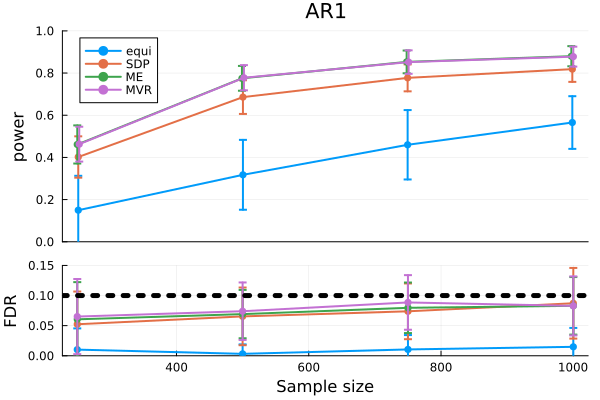

In [3]:
using ProgressMeter
using DataFrames, CSV
using Plots
using LinearAlgebra
using Statistics
Plots.gr(fmt=:png);

function summarize_ar(corr::Bool, n::Int)
    dir = corr ? "/home/groups/sabatti/group_knockoff_simulations/AR1_corr" :
        "/home/groups/sabatti/group_knockoff_simulations/AR1"
    equi_powers, equi_fdrs, equi_times, equi_ssums, equi_obj = [], [], [], [], []
    maxent_powers, maxent_fdrs, maxent_times, maxent_ssums, maxent_obj = [], [], [], [], []
    mvr_powers, mvr_fdrs, mvr_times, mvr_ssums, mvr_obj = [], [], [], [], []
    sdp_powers, sdp_fdrs, sdp_times, sdp_ssums, sdp_obj = [], [], [], [], []
    for seed in 1:1000
        try
            result = CSV.read(joinpath(dir, "sim$seed", "n$n.csv"), DataFrame)
            push!(equi_powers, result[1, "power"]); push!(equi_fdrs, result[1, "fdr"])
            push!(sdp_powers, result[2, "power"]); push!(sdp_fdrs, result[2, "fdr"])
            push!(maxent_powers, result[3, "power"]); push!(maxent_fdrs, result[3, "fdr"])
            push!(mvr_powers, result[4, "power"]); push!(mvr_fdrs, result[4, "fdr"])
        catch
            continue
        end
    end
    println("n $n has $(length(equi_powers)) success")
    return equi_powers, maxent_powers, mvr_powers, sdp_powers, 
        equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs
end
function make_plot_ar(corr::Bool; ns = 250:250:1000)
    equi_powers_mean, equi_fdrs_mean, equi_powers_std, equi_fdrs_std = [], [], [], []
    sdp_powers_mean, sdp_fdrs_mean, sdp_powers_std, sdp_fdrs_std = [], [], [], []
    maxent_powers_mean, maxent_fdrs_mean, maxent_powers_std, maxent_fdrs_std = [], [], [], []
    mvr_powers_mean, mvr_fdrs_mean, mvr_powers_std, mvr_fdrs_std = [], [], [], []
    
    # summarize results
    for n in ns
        equi_powers, maxent_powers, mvr_powers, sdp_powers, 
            equi_fdrs, maxent_fdrs, mvr_fdrs, sdp_fdrs = 
            summarize_ar(corr, n)
        push!(equi_powers_mean, mean(equi_powers)); push!(equi_powers_std, std(equi_powers))
        push!(equi_fdrs_mean, mean(equi_fdrs)); push!(equi_fdrs_std, std(equi_fdrs))
        push!(sdp_powers_mean, mean(sdp_powers)); push!(sdp_powers_std, std(sdp_powers))
        push!(sdp_fdrs_mean, mean(sdp_fdrs)); push!(sdp_fdrs_std, std(sdp_fdrs))
        push!(maxent_powers_mean, mean(maxent_powers)); push!(maxent_powers_std, std(maxent_powers))
        push!(maxent_fdrs_mean, mean(maxent_fdrs)); push!(maxent_fdrs_std, std(maxent_fdrs))
        push!(mvr_powers_mean, mean(mvr_powers)); push!(mvr_powers_std, std(mvr_powers))
        push!(mvr_fdrs_mean, mean(mvr_fdrs)); push!(mvr_fdrs_std, std(mvr_fdrs))
    end
    
    # power plot
    title = corr ? "AR1(corr)" : "AR1"
    power_plt = plot(ns, equi_powers_mean, yerr=equi_powers_std, xtick=false, shape=:circle,
        ylabel="power", label="equi", w=2, ylim=(0, 1.0), title=title, markerstrokecolor=:auto, capsize = 0)
    plot!(ns, sdp_powers_mean, yerr=sdp_powers_std, label = "SDP", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .- 1.5, maxent_powers_mean, yerr=maxent_powers_std, label = "ME", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)
    plot!(ns .+ 1.5, mvr_powers_mean, yerr=mvr_powers_std, label = "MVR", w=2, shape=:circle, markerstrokecolor=:auto, capsize = 0)

    # FDR plots
    fdr_plt = plot(ns, equi_fdrs_mean, xlabel="Sample size", yerr=equi_fdrs_std, 
        ylabel="FDR", label="equi", w=2, ylim=(0, 0.15), shape=:circle, markerstrokecolor=:auto, )
    plot!(ns, sdp_fdrs_mean, label = "SDP", w=2, shape=:circle, yerr=sdp_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, maxent_fdrs_mean, label = "ME", w=2, shape=:circle, yerr=maxent_fdrs_std, markerstrokecolor=:auto)
    plot!(ns, mvr_fdrs_mean, label = "MVR", w=2, shape=:circle, yerr=mvr_fdrs_std, markerstrokecolor=:auto)
    hline!(fdr_plt, [0.1], label = "target FDR", linestyle=:dot, w=5, color=:black, legend=false)
    
    @show maxent_fdrs_mean
    
    return power_plt, fdr_plt
end

AR1_power_plt, AR1_fdr_plt = make_plot_ar(false)
plot(AR1_power_plt, AR1_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))

n 250 has 100 success
n 500 has 100 success
n 750 has 100 success
n 1000 has 100 success
maxent_fdrs_mean = Any[0.06497326194617215, 0.08053803514864556, 0.08615491621643191, 0.0993834816514159]


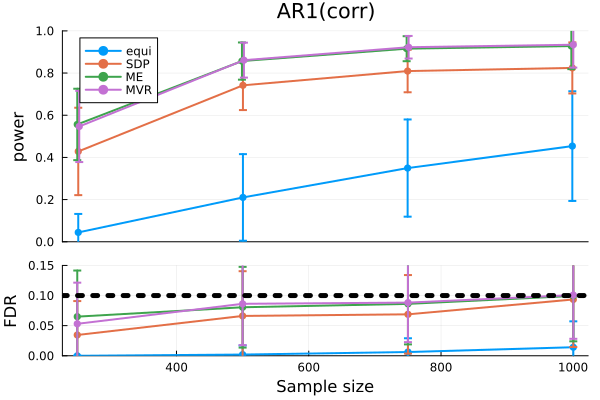

In [4]:
AR1_power_plt, AR1_fdr_plt = make_plot_ar(true)
plot(AR1_power_plt, AR1_fdr_plt, layout = grid(2, 1, heights=[0.7 ,0.3]))